<a href="https://colab.research.google.com/github/regiiis/dlv_group_project/blob/main/dlv_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DLV Group Project

## Set up

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Jun 30 10:19:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from numpy import asarray
from numpy import savetxt
import pandas as pd
import os, datetime
import math
import sys
from PIL import Image

# General imports
import tensorflow as tf
tf.compat.v1.enable_eager_execution(
    config=None, device_policy=None, execution_mode=None)

# Shortcuts to keras if (however from tensorflow)
from tensorflow import keras
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard 
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical

from IPython.display import Image

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight


Populating the interactive namespace from numpy and matplotlib


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/My Drive/Colab Notebooks/data/2020-02-14_InfraredSolarModules.zip"

In [5]:
df = pd.read_json("/content/InfraredSolarModules/module_metadata.json",orient="index")
df['image_name'] = df['image_filepath'].str[7:]
df

,image_filepath,anomaly_class,image_name
13357,images/13357.jpg,No-Anomaly,13357.jpg
13356,images/13356.jpg,No-Anomaly,13356.jpg
19719,images/19719.jpg,No-Anomaly,19719.jpg
11542,images/11542.jpg,No-Anomaly,11542.jpg
11543,images/11543.jpg,No-Anomaly,11543.jpg
...,...,...,...
8488,images/8488.jpg,Vegetation,8488.jpg
8489,images/8489.jpg,Vegetation,8489.jpg
7464,images/7464.jpg,Cracking,7464.jpg
18065,images/18065.jpg,No-Anomaly,18065.jpg


In [6]:
reduced_df = df.sample(frac=0.8,random_state=200)       # random state is a seed value
train_df = reduced_df.sample(frac=0.8,random_state=200) # random state is a seed value
validation_test_df = reduced_df.drop(train_df.index)
validation_df = validation_test_df.sample(frac=0.5,random_state=200)
test_df = validation_test_df.drop(validation_df.index)

print(train_df.info())
print()
print(validation_df.info())
print()
test_df.info()

test_df.anomaly_class

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12800 entries, 19208 to 2880
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   image_filepath  12800 non-null  object
 1   anomaly_class   12800 non-null  object
 2   image_name      12800 non-null  object
dtypes: object(3)
memory usage: 400.0+ KB
None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600 entries, 12389 to 2391
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   image_filepath  1600 non-null   object
 1   anomaly_class   1600 non-null   object
 2   image_name      1600 non-null   object
dtypes: object(3)
memory usage: 50.0+ KB
None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600 entries, 2358 to 14124
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   image_filepath  1600 non-null   object
 1

2358          Diode
9560     Vegetation
17012    No-Anomaly
6147           Cell
11880    No-Anomaly
            ...    
1520          Diode
1330          Diode
4781     Cell-Multi
14401    No-Anomaly
14124    No-Anomaly
Name: anomaly_class, Length: 1600, dtype: object

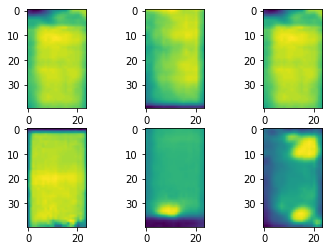

In [7]:
img1 = mpimg.imread('/content/InfraredSolarModules/images/13356.jpg') #No-Anomaly
img12 = mpimg.imread('/content/InfraredSolarModules/images/11880.jpg') #No-Anomaly
img13 = mpimg.imread('/content/InfraredSolarModules/images/13356.jpg') #No-Anomaly
img2 = mpimg.imread('/content/InfraredSolarModules/images/8488.jpg')  #Vegetation
img3 = mpimg.imread('/content/InfraredSolarModules/images/8489.jpg')  #Vegetation
img4 = mpimg.imread('/content/InfraredSolarModules/images/7464.jpg')  #Cracking

f, axarr = plt.subplots(2,3)
axarr[0,0].imshow(img1)
axarr[0,1].imshow(img12)
axarr[0,2].imshow(img13)
axarr[1,0].imshow(img2)
axarr[1,1].imshow(img3)
axarr[1,2].imshow(img4)

## **Feature Extraction** - Load Base Model

In [8]:
image_height = 40
image_width = 32
batch_size = 64

datagen_train = ImageDataGenerator(rescale=1./255)
datagen_validation = ImageDataGenerator(rescale=1./255)

train_generator = datagen_train.flow_from_dataframe(
    dataframe = train_df,
    directory = "/content/InfraredSolarModules/images/",
    x_col = "image_name",
    y_col = "anomaly_class",
    class_mode = "categorical",
    target_size = (image_height, image_width),
    batch_size = batch_size,
    color_mode = "rgb"
)

val_generator = datagen_train.flow_from_dataframe(
    dataframe = validation_df,
    directory = "/content/InfraredSolarModules/images/",
    x_col = "image_name",
    y_col = "anomaly_class",
    class_mode = "categorical",
    target_size = (image_height, image_width),
    batch_size = batch_size,
    color_mode = "rgb"
     )

Found 12800 validated image filenames belonging to 12 classes.
Found 1600 validated image filenames belonging to 12 classes.


In [29]:
base_model = VGG16(
    input_shape=(image_width,image_height,3),
    include_top=False,
    weights="imagenet"
)

for layer in base_model.layers:
    layer.trainable=False
    
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 40, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 40, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 40, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 20, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 20, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 20, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 10, 128)        0     

## Model_1 - Without Data Augmentation

In [10]:
base_model_1 = base_model

model_1 = tf.keras.models.Sequential([
    base_mode_1,
    
    Flatten(),    
    Dense(256,activation="relu"),
    BatchNormalization(),
    Dropout(0.5),
    Dense(12, activation='softmax')
])

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 12)                3084      
                                                        

#### Compute Model

In [11]:
model_1.compile(loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"])


logdir = os.path.join("logs_feature_extraction", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))


callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="feature_extraction.h5", save_best_only=True, monitor="val_loss"),
    tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
]

history = model_1.fit(
train_generator,
epochs=30,
validation_data=(val_generator),
callbacks=callbacks
)

Epoch 1/30
200/200 [==============================] - 17s 27ms/step - loss: 1.6199 - accuracy: 0.5383 - val_loss: 1.5362 - val_accuracy: 0.5069
Epoch 2/30
200/200 [==============================] - 6s 29ms/step - loss: 1.2777 - accuracy: 0.6177 - val_loss: 1.2619 - val_accuracy: 0.5969
Epoch 3/30
200/200 [==============================] - 5s 27ms/step - loss: 1.1993 - accuracy: 0.6303 - val_loss: 1.1931 - val_accuracy: 0.6250
Epoch 4/30
200/200 [==============================] - 5s 27ms/step - loss: 1.1544 - accuracy: 0.6484 - val_loss: 1.1063 - val_accuracy: 0.6544
Epoch 5/30
200/200 [==============================] - 5s 27ms/step - loss: 1.1245 - accuracy: 0.6488 - val_loss: 1.0871 - val_accuracy: 0.6656
Epoch 6/30
200/200 [==============================] - 5s 26ms/step - loss: 1.1046 - accuracy: 0.6519 - val_loss: 1.1503 - val_accuracy: 0.6388
Epoch 7/30
200/200 [==============================] - 5s 26ms/step - loss: 1.0932 - accuracy: 0.6576 - val_loss: 1.1841 - val_accuracy: 0.641

#### Model Performance

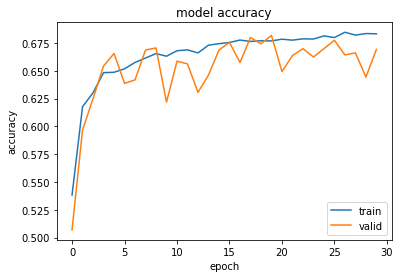

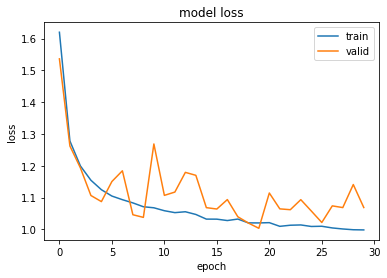

In [12]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [13]:
 model_1.evaluate(val_generator)

25/25 [==============================] - 0s 18ms/step - loss: 1.0685 - accuracy: 0.6694


[1.0684747695922852, 0.6693750023841858]

### Addition: Fine Tuning

The steps for fine-tuning are as follows:

1. Add our custom network on top of an already-trained base network.
2. Freeze the base network.
3. Train the part we added.
4. Unfreeze some layers in the base network. (Note that you should not unfreeze “batch normalization” layers, which are not relevant here since there are no such layers in VGG16)
5. Jointly train both these layers and the part we added.

In [14]:
base_model_1.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 40, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 40, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 40, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 20, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 20, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 20, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 10, 128)        0     

In [15]:
# Freeze all layers until the block_5_ layers

base_model_1.trainable = True
for layer in base_model_1.layers[:-4]:
    layer.trainable = False
    
for layer in base_model_1.layers[0:]:
    print('layer name = ' + layer.name + ', shape = ' + repr(layer.output_shape)
            + ', trainable = ' + repr(layer.trainable))  

layer name = input_1, shape = [(None, 32, 40, 3)], trainable = False
layer name = block1_conv1, shape = (None, 32, 40, 64), trainable = False
layer name = block1_conv2, shape = (None, 32, 40, 64), trainable = False
layer name = block1_pool, shape = (None, 16, 20, 64), trainable = False
layer name = block2_conv1, shape = (None, 16, 20, 128), trainable = False
layer name = block2_conv2, shape = (None, 16, 20, 128), trainable = False
layer name = block2_pool, shape = (None, 8, 10, 128), trainable = False
layer name = block3_conv1, shape = (None, 8, 10, 256), trainable = False
layer name = block3_conv2, shape = (None, 8, 10, 256), trainable = False
layer name = block3_conv3, shape = (None, 8, 10, 256), trainable = False
layer name = block3_pool, shape = (None, 4, 5, 256), trainable = False
layer name = block4_conv1, shape = (None, 4, 5, 512), trainable = False
layer name = block4_conv2, shape = (None, 4, 5, 512), trainable = False
layer name = block4_conv3, shape = (None, 4, 5, 512), train

#### Compute Fine Tuning

In [16]:
model_1.compile(loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    metrics=["accuracy"])

In [17]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 12)                3084      
                                                        

In [18]:
logdir = os.path.join("logs_fine_tuning", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))


callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="fine_tuning.keras", save_best_only=True, monitor="val_loss"),
    tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
]

history = model_1.fit(
train_generator,
epochs=30,
validation_data = val_generator,
callbacks = callbacks
)

Epoch 1/30
200/200 [==============================] - 7s 29ms/step - loss: 0.9860 - accuracy: 0.6849 - val_loss: 0.9701 - val_accuracy: 0.6888
Epoch 2/30
200/200 [==============================] - 6s 28ms/step - loss: 0.9012 - accuracy: 0.7131 - val_loss: 0.9392 - val_accuracy: 0.6913
Epoch 3/30
200/200 [==============================] - 5s 26ms/step - loss: 0.8528 - accuracy: 0.7253 - val_loss: 0.9851 - val_accuracy: 0.6994
Epoch 4/30
200/200 [==============================] - 6s 28ms/step - loss: 0.8233 - accuracy: 0.7349 - val_loss: 0.8873 - val_accuracy: 0.7150
Epoch 5/30
200/200 [==============================] - 5s 26ms/step - loss: 0.7830 - accuracy: 0.7473 - val_loss: 0.9911 - val_accuracy: 0.6931
Epoch 6/30
200/200 [==============================] - 6s 29ms/step - loss: 0.7693 - accuracy: 0.7539 - val_loss: 0.8409 - val_accuracy: 0.7319
Epoch 7/30
200/200 [==============================] - 5s 27ms/step - loss: 0.7279 - accuracy: 0.7655 - val_loss: 0.8428 - val_accuracy: 0.7350

#### Model Performance - With Fine Tuning

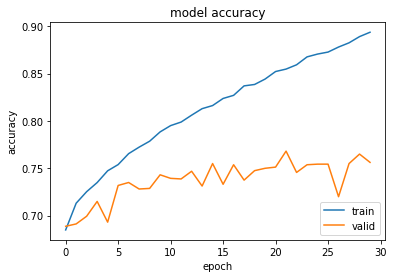

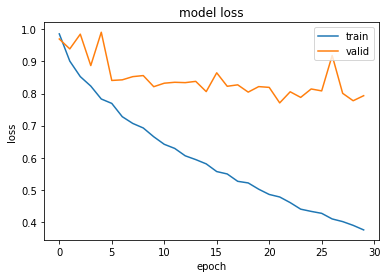

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [20]:
 model_1.evaluate(val_generator)

25/25 [==============================] - 0s 17ms/step - loss: 0.7933 - accuracy: 0.7563


[0.7933217883110046, 0.7562500238418579]

In [21]:
train_generator.class_indices

{'Cell': 0,
 'Cell-Multi': 1,
 'Cracking': 2,
 'Diode': 3,
 'Diode-Multi': 4,
 'Hot-Spot': 5,
 'Hot-Spot-Multi': 6,
 'No-Anomaly': 7,
 'Offline-Module': 8,
 'Shadowing': 9,
 'Soiling': 10,
 'Vegetation': 11}

In [22]:
x = list(train_generator.class_indices.keys())
num_of_test_samples = 1600

Y_pred = model_1.predict_generator(val_generator, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print()
print('Confusion Matrix')
print(confusion_matrix(val_generator.classes, y_pred))

print()
print('Classification Report')
target_names = x
print(classification_report(val_generator.classes, y_pred, target_names = target_names))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  after removing the cwd from sys.path.



Confusion Matrix
[[ 13   5  12   7   3   0   4  73   2   4   0   9]
 [ 11   4   5   2   0   0   1  78   0   5   0   7]
 [ 11   2   2   9   1   1   1  58   1   6   0   6]
 [ 12   4   7  13   0   0   0  66   4   4   0   7]
 [  1   0   2   1   0   0   0  10   0   0   0   3]
 [  2   0   0   1   0   0   0  10   2   2   0   3]
 [  1   1   2   1   0   0   0  10   0   0   0   3]
 [ 74  25  39  50   5   3   8 461  22  23   3  64]
 [  6   4   2   6   0   0   0  34   0   2   1   4]
 [ 11   8   5   4   0   1   2  47   0   4   1   9]
 [  1   1   0   5   0   0   0   7   0   1   0   0]
 [ 16   5   6   7   2   0   0  84   5   3   1  13]]

Classification Report
                precision    recall  f1-score   support

          Cell       0.08      0.10      0.09       132
    Cell-Multi       0.07      0.04      0.05       113
      Cracking       0.02      0.02      0.02        98
         Diode       0.12      0.11      0.12       117
   Diode-Multi       0.00      0.00      0.00        17
      Hot

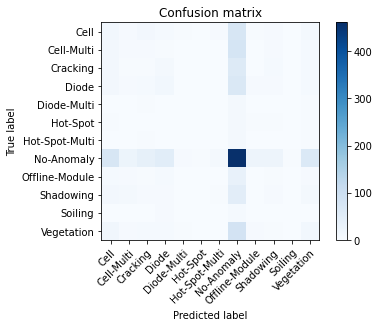

In [23]:
cm = confusion_matrix(val_generator.classes, y_pred)
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
title = 'Confusion matrix'
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
    yticks=np.arange(cm.shape[0]),
    xticklabels=target_names, yticklabels=target_names,
    title=title,
    ylabel='True label',
    xlabel='Predicted label')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
np.set_printoptions(precision=2)
plt.show()

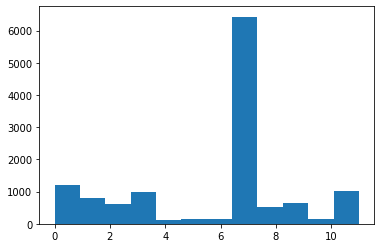

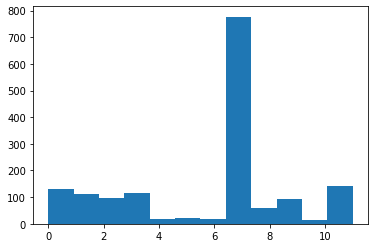

In [24]:
x = list(train_generator.class_indices.keys())
y = train_generator.classes
plt.hist(y, bins = 12)
plt.show()
y = val_generator.classes
plt.hist(y, bins = 12)
plt.show()

## Model_2 - With Imbalanced Data Handling

### Compute Weights

In [25]:
train_classes = np.unique(train_generator.classes)
print(train_classes)
train_generator.classes
print(train_generator.classes)

train_classes = train_generator.classes
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_classes),
                                        y = train_classes                                                    
                                    )
class_weights = dict(zip(np.unique(train_classes), class_weights))
class_weights

[ 0  1  2  3  4  5  6  7  8  9 10 11]
[7, 9, 7, 0, 9, 7, 7, 1, 1, 11, 6, 11, 7, 10, 2, 7, 3, 7, 7, 1, 7, 0, 11, 7, 5, 7, 0, 7, 7, 7, 7, 9, 7, 8, 9, 7, 9, 9, 7, 7, 7, 11, 1, 7, 7, 7, 0, 7, 4, 3, 7, 7, 7, 7, 8, 11, 1, 3, 0, 7, 11, 7, 0, 7, 7, 1, 0, 11, 0, 1, 7, 7, 7, 7, 1, 7, 7, 7, 8, 7, 9, 7, 8, 7, 7, 7, 11, 7, 1, 10, 7, 7, 7, 7, 0, 0, 7, 6, 2, 7, 7, 7, 3, 7, 7, 3, 7, 7, 3, 7, 9, 7, 7, 7, 0, 1, 8, 7, 11, 10, 11, 3, 3, 7, 2, 3, 7, 7, 7, 7, 8, 7, 7, 7, 3, 8, 11, 7, 0, 7, 7, 1, 11, 7, 7, 0, 8, 7, 4, 7, 0, 0, 8, 7, 7, 7, 7, 0, 3, 6, 7, 7, 11, 5, 11, 9, 11, 7, 7, 7, 2, 1, 11, 7, 2, 10, 7, 7, 11, 11, 7, 7, 0, 2, 3, 7, 1, 7, 7, 0, 7, 3, 7, 7, 7, 7, 0, 11, 11, 11, 7, 7, 7, 7, 8, 0, 7, 9, 0, 7, 7, 11, 0, 7, 7, 7, 2, 9, 7, 7, 7, 10, 7, 11, 7, 1, 7, 7, 7, 7, 6, 7, 0, 7, 1, 10, 9, 7, 0, 7, 8, 1, 7, 7, 3, 7, 7, 7, 3, 11, 11, 11, 0, 3, 7, 7, 7, 7, 0, 7, 3, 7, 7, 11, 7, 7, 7, 11, 2, 7, 7, 0, 7, 2, 7, 7, 5, 1, 1, 0, 1, 1, 1, 11, 7, 7, 7, 7, 8, 7, 1, 7, 7, 7, 7, 2, 2, 7, 7, 10, 1, 0, 7, 1, 9, 7, 11, 1, 

{0: 0.8844665561083471,
 1: 1.3152486642005754,
 2: 1.7660044150110374,
 3: 1.0962658444672833,
 4: 9.696969696969697,
 5: 6.666666666666667,
 6: 7.017543859649122,
 7: 0.16581170008808746,
 8: 2.0087884494664157,
 9: 1.6334864726901481,
 10: 7.785888077858881,
 11: 1.035598705501618}

### Compute Model - Weight Compensated

In [32]:
base_model_2 = base_model

model_2 = tf.keras.models.Sequential([
    base_model_2,
    
    Flatten(),    
    Dense(256,activation="relu"),
    BatchNormalization(),
    Dropout(0.35),
    Dense(12, activation='softmax')
])

model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 batch_normalization_2 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 12)                3084      
                                                      

In [33]:
model_2.compile(loss = "categorical_crossentropy",
    optimizer = keras.optimizers.Adam(learning_rate=1e-4),
    metrics = ["accuracy"])

logdir = os.path.join("logs_feature_extraction", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))


callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="feature_extraction.h5", save_best_only=True, monitor="val_loss"),
    tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
]

history = model_2.fit(
train_generator,
epochs = 60,
validation_data=(val_generator),
class_weight = class_weights,
callbacks = callbacks
)

Epoch 1/60
200/200 [==============================] - 6s 26ms/step - loss: 2.4653 - accuracy: 0.1334 - val_loss: 2.2519 - val_accuracy: 0.2262
Epoch 2/60
200/200 [==============================] - 6s 32ms/step - loss: 2.1528 - accuracy: 0.2095 - val_loss: 2.0591 - val_accuracy: 0.3569
Epoch 3/60
200/200 [==============================] - 6s 30ms/step - loss: 2.0064 - accuracy: 0.2623 - val_loss: 2.0296 - val_accuracy: 0.2875
Epoch 4/60
200/200 [==============================] - 6s 29ms/step - loss: 1.9362 - accuracy: 0.2932 - val_loss: 1.8696 - val_accuracy: 0.3556
Epoch 5/60
200/200 [==============================] - 6s 28ms/step - loss: 1.8656 - accuracy: 0.3159 - val_loss: 1.7851 - val_accuracy: 0.4338
Epoch 6/60
200/200 [==============================] - 5s 26ms/step - loss: 1.7943 - accuracy: 0.3345 - val_loss: 1.7900 - val_accuracy: 0.4169
Epoch 7/60
200/200 [==============================] - 5s 26ms/step - loss: 1.7782 - accuracy: 0.3403 - val_loss: 1.6778 - val_accuracy: 0.4856

#### Model Performance - Weight Compensated

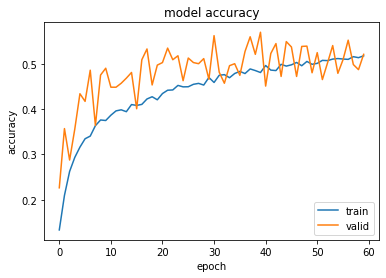

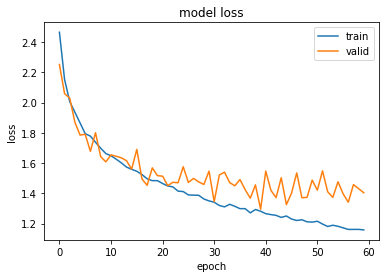

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [35]:
 model_2.evaluate(val_generator)

25/25 [==============================] - 0s 17ms/step - loss: 1.4036 - accuracy: 0.5206


[1.403630256652832, 0.5206249952316284]

In [36]:
x = list(train_generator.class_indices.keys())
num_of_test_samples = 1600

Y_pred = model_2.predict_generator(val_generator, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print()
print('Confusion Matrix')
print(confusion_matrix(val_generator.classes, y_pred))

print()
print('Classification Report')
target_names = x
print(classification_report(val_generator.classes, y_pred, target_names = target_names))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  after removing the cwd from sys.path.



Confusion Matrix
[[  7  15   8   7   5   7   1  42  16  10   5   9]
 [ 14   2   6   7   2   8   5  38   7  13   4   7]
 [  9   3   9  10   2   9   4  33   5   7   3   4]
 [ 13   4  10   8   4   9   5  29  11  11   5   8]
 [  0   1   1   1   1   2   1   4   2   3   0   1]
 [  2   0   1   2   2   1   1   7   2   1   1   0]
 [  4   0   4   3   0   0   1   2   2   1   0   1]
 [ 84  48  40  60  31  32  30 229  74  76  30  43]
 [ 10   2   7   3   1   4   3  12   5   2   6   4]
 [  8   2   9   8   3   4   5  24   1  15   5   8]
 [  2   1   1   1   0   1   1   5   0   2   1   0]
 [ 17   6   6  12   6   0  11  39  14  15   7   9]]

Classification Report
                precision    recall  f1-score   support

          Cell       0.04      0.05      0.05       132
    Cell-Multi       0.02      0.02      0.02       113
      Cracking       0.09      0.09      0.09        98
         Diode       0.07      0.07      0.07       117
   Diode-Multi       0.02      0.06      0.03        17
      Hot

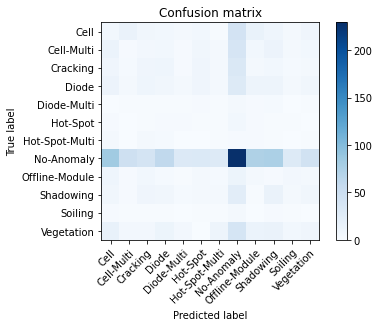

In [37]:
cm = confusion_matrix(val_generator.classes, y_pred)
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
title = 'Confusion matrix'
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
    yticks=np.arange(cm.shape[0]),
    xticklabels=target_names, yticklabels=target_names,
    title=title,
    ylabel='True label',
    xlabel='Predicted label')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
np.set_printoptions(precision=2)
plt.show()

### Layer Visualization

#### Intermediate Layers

In [ ]:
img_path = '/content/InfraredSolarModules/images/1.jpg'

def get_img_array(img_path, target_size):
    # Open the image file and resize it.
    img = keras.utils.load_img(img_path, target_size=target_size)
    # Turn the image into a float32 NumPy array of shape (150, 150, 3)
    array = keras.utils.img_to_array(img)
    # Add a dimension to transform the array into
    # a “batch” of a single sample. Its shape is now
    # (1, 150, 150, 3)
    array = np.expand_dims(array, axis=0)
    return array


img_tensor = get_img_array(img_path, target_size=(32, 40))


print(img_tensor.shape)

(1, 32, 40, 3)


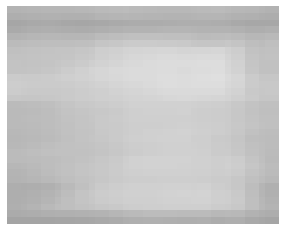

In [ ]:
import matplotlib.pyplot as plt
plt.axis("off")
plt.imshow(img_tensor[0].astype("uint8"))
plt.show()

In [ ]:
layer_outputs = []
layer_names = []
for layer in model.layers:
    # Extract the outputs of all Conv2D and MaxPooling2D layers and put them in a list.
    if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D)):
        layer_outputs.append(layer.output)
        # Save the layer names for later
        layer_names.append(layer.name)
# Create a model that will return these outputs, given the model input.        
activation_model = keras.Model(inputs=model.input, outputs=layer_outputs)

In [ ]:
# Return a list of nine NumPy arrays: one array per layer activation.
activations = activation_model.predict(img_tensor)

In [ ]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

IndexError: ignored

In [ ]:
plt.matshow(first_layer_activation[0, :, :, 5], cmap="viridis")

NameError: ignored

In [ ]:
images_per_row = 16
# Iterate over the activations (and the names of the corresponding layers)
for layer_name, layer_activation in zip(layer_names, activations):
    # The layer activation has shape (1, size, size, n_features)
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    # Prepare an empty grid for displaying all the channels in this activation.
    display_grid = np.zeros(((size + 1) * n_cols - 1, images_per_row * (size + 1) - 1))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_index = col * images_per_row + row
            # This is a single channel (or feature)
            channel_image = layer_activation[0, :, :, channel_index].copy()
            # Normalize channel values within the [0, 255] range. Allzero
            # channels are kept at zero.
            if channel_image.sum() != 0:
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype("uint8")
            # Place the channel matrix in the empty grid we prepared.
            display_grid[col * (size + 1): (col + 1) * size + col, row * (size + 1) : (row + 1) * size + row] = channel_image

    # Display the grid for the layer.
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.axis("off")
    plt.imshow(display_grid, aspect="auto", cmap="viridis")

#### Convnet Filters

In [ ]:
# summarize filter shapes
for layer in model.layers:
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
    # get filter weights
    filters, biases = layer.get_weights()
    print(layer.name, filters.shape)

In [ ]:
# retrieve weights from the first hidden layer
filters, biases = model.layers[0].get_weights()
print(filters.shape, biases.shape, filters.dtype)

ValueError: ignored

In [ ]:
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

NameError: ignored

In [ ]:
# plot all 32 filters
n_filters = 32
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    ax = plt.subplot(8, 4 , i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(f)
# show the figure
plt.show()

In [ ]:
# plot first few filters
n_filters, ix = 6, 1
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(3):
        # specify subplot and turn of axis
        ax = plt.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(f[:, :, j], cmap='gray')
        ix += 1
# show the figure
plt.show()

### Fine Tuning - Weight Compensated

In [38]:
# Freeze all layers until the block_5_ layers
base_model_2.trainable = True
for layer in base_model_2.layers[:-4]:
    layer.trainable = False
    
for layer in base_model_2.layers[0:]:
    print('layer name = ' + layer.name + ', shape = ' + repr(layer.output_shape)
            + ', trainable = ' + repr(layer.trainable))  

layer name = input_5, shape = [(None, 32, 40, 3)], trainable = False
layer name = block1_conv1, shape = (None, 32, 40, 64), trainable = False
layer name = block1_conv2, shape = (None, 32, 40, 64), trainable = False
layer name = block1_pool, shape = (None, 16, 20, 64), trainable = False
layer name = block2_conv1, shape = (None, 16, 20, 128), trainable = False
layer name = block2_conv2, shape = (None, 16, 20, 128), trainable = False
layer name = block2_pool, shape = (None, 8, 10, 128), trainable = False
layer name = block3_conv1, shape = (None, 8, 10, 256), trainable = False
layer name = block3_conv2, shape = (None, 8, 10, 256), trainable = False
layer name = block3_conv3, shape = (None, 8, 10, 256), trainable = False
layer name = block3_pool, shape = (None, 4, 5, 256), trainable = False
layer name = block4_conv1, shape = (None, 4, 5, 512), trainable = False
layer name = block4_conv2, shape = (None, 4, 5, 512), trainable = False
layer name = block4_conv3, shape = (None, 4, 5, 512), train

In [39]:
model_2.compile(loss = "categorical_crossentropy",
    optimizer = keras.optimizers.Adam(learning_rate=1e-5),
    metrics = ["accuracy"])

In [40]:
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 batch_normalization_2 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 12)                3084      
                                                      

In [41]:
logdir = os.path.join("logs_fine_tuning", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))


callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="fine_tuning.keras", save_best_only=True, monitor="val_loss"),
    tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
]

history = model_2.fit(
train_generator,
epochs=60,
validation_data = val_generator,
class_weight = class_weights,
callbacks = callbacks
)

Epoch 1/60
200/200 [==============================] - 6s 28ms/step - loss: 1.2559 - accuracy: 0.4936 - val_loss: 1.6133 - val_accuracy: 0.4162
Epoch 2/60
200/200 [==============================] - 6s 28ms/step - loss: 1.1409 - accuracy: 0.5208 - val_loss: 1.5165 - val_accuracy: 0.4956
Epoch 3/60
200/200 [==============================] - 6s 28ms/step - loss: 1.0770 - accuracy: 0.5386 - val_loss: 1.2515 - val_accuracy: 0.5888
Epoch 4/60
200/200 [==============================] - 5s 27ms/step - loss: 1.0194 - accuracy: 0.5595 - val_loss: 1.4718 - val_accuracy: 0.5138
Epoch 5/60
200/200 [==============================] - 6s 30ms/step - loss: 0.9993 - accuracy: 0.5566 - val_loss: 1.2190 - val_accuracy: 0.5944
Epoch 6/60
200/200 [==============================] - 5s 27ms/step - loss: 0.9612 - accuracy: 0.5744 - val_loss: 1.2756 - val_accuracy: 0.5838
Epoch 7/60
200/200 [==============================] - 5s 26ms/step - loss: 0.9192 - accuracy: 0.5816 - val_loss: 1.2441 - val_accuracy: 0.5962

#### Model Performance - With Fine Tuning

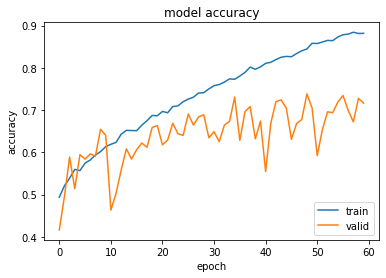

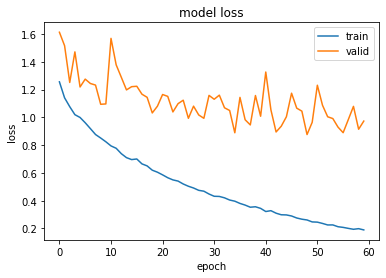

In [42]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [43]:
 model_2.evaluate(val_generator)

25/25 [==============================] - 0s 17ms/step - loss: 0.9732 - accuracy: 0.7163


[0.9732373952865601, 0.7162500023841858]

In [44]:
x = list(train_generator.class_indices.keys())
num_of_test_samples = 1600

Y_pred = model_2.predict_generator(val_generator, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print()
print('Confusion Matrix')
print(confusion_matrix(val_generator.classes, y_pred))

print()
print('Classification Report')
target_names = x
print(classification_report(val_generator.classes, y_pred, target_names = target_names))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  after removing the cwd from sys.path.



Confusion Matrix
[[  7   5   5  13   3   1   1  56  14  10   4  13]
 [ 10   4   6   6   3   2   2  45   7  16   2  10]
 [  6   5   6   4   1   3   2  45   8   6   2  10]
 [  9  11   8   5   0   1   1  51   4  15   1  11]
 [  2   0   1   2   0   0   0   5   1   1   1   4]
 [  0   0   2   5   0   1   0   6   2   2   1   1]
 [  3   1   0   0   1   1   0   6   1   3   1   1]
 [ 57  37  41  67   8  11  12 332  40  68  11  93]
 [  3   5   3   7   1   1   0  22   7   3   0   7]
 [  6   4   4   9   1   0   3  43   7   5   1   9]
 [  3   1   1   4   0   0   0   2   1   1   0   2]
 [ 11   9   9  15   1   3   4  52   8  12   0  18]]

Classification Report
                precision    recall  f1-score   support

          Cell       0.06      0.05      0.06       132
    Cell-Multi       0.05      0.04      0.04       113
      Cracking       0.07      0.06      0.07        98
         Diode       0.04      0.04      0.04       117
   Diode-Multi       0.00      0.00      0.00        17
      Hot

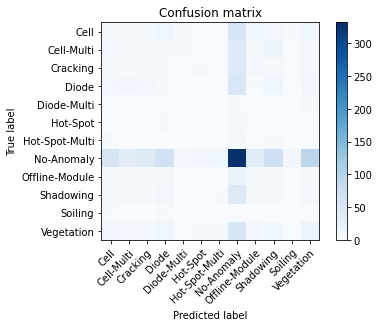

In [45]:
cm = confusion_matrix(val_generator.classes, y_pred)
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
title = 'Confusion matrix'
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
    yticks=np.arange(cm.shape[0]),
    xticklabels=target_names, yticklabels=target_names,
    title=title,
    ylabel='True label',
    xlabel='Predicted label')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
np.set_printoptions(precision=2)
plt.show()

## Model_3 - With Augmentation

### Compute Model

In [ ]:
image_height = 40
image_width = 32
batch_size = 32

train_datagen_3 = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.01,
        zoom_range=0.005,)

validation_datagen_3 = ImageDataGenerator(rescale=1./255)


train_generator_3 = train_datagen_3.flow_from_dataframe(
    dataframe = train_df,
    directory = "/content/InfraredSolarModules/images/",
    x_col = "image_name",
    y_col = "anomaly_class",
    class_mode = "categorical",
    target_size = (image_height, image_width),
    batch_size = batch_size,
    color_mode = "rgb"
)

validation_generator_3 = validation_datagen_3.flow_from_dataframe(
    dataframe = validation_df,
    directory = "/content/InfraredSolarModules/images/",
    x_col = "image_name",
    y_col = "anomaly_class",
    class_mode = "categorical",
    target_size = (image_height, image_width),
    batch_size = batch_size,
    color_mode = "rgb"
     )

Found 12800 validated image filenames belonging to 12 classes.
Found 1600 validated image filenames belonging to 12 classes.


In [ ]:
train_classes_3 = np.unique(train_generator_3.classes)
train_generator_3.classes

train_classes_3 = train_generator_3.classes
class_weights_3 = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_classes_3),
                                        y = train_classes_3                                                    
                                    )
class_weights_3 = dict(zip(np.unique(train_classes), class_weights_3))
class_weights_3

{0: 0.8844665561083471,
 1: 1.3152486642005754,
 2: 1.7660044150110374,
 3: 1.0962658444672833,
 4: 9.696969696969697,
 5: 6.666666666666667,
 6: 7.017543859649122,
 7: 0.16581170008808746,
 8: 2.0087884494664157,
 9: 1.6334864726901481,
 10: 7.785888077858881,
 11: 1.035598705501618}

In [ ]:
base_model_3 = base_model

base_model_3 = VGG16(
    input_shape=(image_width,image_height,3),
    include_top=False,
    weights="imagenet"
)

for layer in base_model_3.layers:
    layer.trainable=False

In [ ]:
model_3 = tf.keras.models.Sequential([
    base_model_3,
    
    Flatten(),    
    Dense(256,activation="relu"),
    BatchNormalization(),
    Dropout(0.5),
    Dense(12, activation='softmax')
])

In [ ]:
model_3.compile(loss = "categorical_crossentropy",
    optimizer = keras.optimizers.Adam(learning_rate = 1e-4),
    metrics = ["accuracy"])

logdir = os.path.join("logs_feature_extraction_with_augmentation", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="feature_extraction_with_augmentation.h5", save_best_only=True, monitor="val_loss"),
    tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
]

history = model_3.fit(
    train_generator_3,
    epochs = 120,
    validation_data = validation_generator_3,
    class_weight = class_weights,
    callbacks = callbacks)

Epoch 1/80
400/400 [==============================] - 12s 29ms/step - loss: 2.4345 - accuracy: 0.1886 - val_loss: 1.9580 - val_accuracy: 0.3650
Epoch 2/80
400/400 [==============================] - 11s 28ms/step - loss: 2.0931 - accuracy: 0.2587 - val_loss: 2.0611 - val_accuracy: 0.2306
Epoch 3/80
400/400 [==============================] - 11s 28ms/step - loss: 1.9399 - accuracy: 0.3139 - val_loss: 1.9314 - val_accuracy: 0.3487
Epoch 4/80
400/400 [==============================] - 11s 28ms/step - loss: 1.8416 - accuracy: 0.3334 - val_loss: 1.7955 - val_accuracy: 0.3931
Epoch 5/80
400/400 [==============================] - 11s 27ms/step - loss: 1.7930 - accuracy: 0.3541 - val_loss: 1.5769 - val_accuracy: 0.5075
Epoch 6/80
400/400 [==============================] - 11s 27ms/step - loss: 1.7244 - accuracy: 0.3619 - val_loss: 1.8200 - val_accuracy: 0.3200
Epoch 7/80
400/400 [==============================] - 11s 27ms/step - loss: 1.6611 - accuracy: 0.3697 - val_loss: 1.5839 - val_accuracy:

### Model Performance - With Augmentation

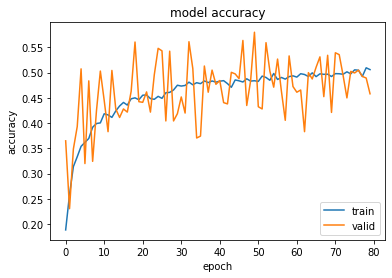

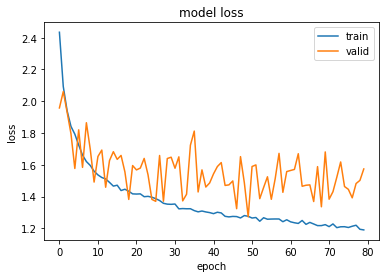

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [ ]:
model_3.evaluate(validation_generator_3)

50/50 [==============================] - 1s 11ms/step - loss: 1.5739 - accuracy: 0.4581


[1.5738835334777832, 0.4581249952316284]

In [ ]:
x = list(train_generator_3.class_indices.keys())
num_of_test_samples = 1600

Y_pred = model_3.predict_generator(validation_generator_3, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print()
print('Confusion Matrix')
print(confusion_matrix(validation_generator_3.classes, y_pred))

print()
print('Classification Report')
target_names = x
print(classification_report(validation_generator_3.classes, y_pred, target_names = target_names))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  after removing the cwd from sys.path.



Confusion Matrix
[[  7   8   6  18   4  14   4  25  11  16  10   9]
 [  4   6   5  14   5  13   7  24   8  12   4  11]
 [  4   5   6  15   4  10   3  21   4  13   5   8]
 [  2   7   4  10   2  14   9  31  12  10   6  10]
 [  0   2   1   1   1   2   0   6   2   2   0   0]
 [  1   0   3   2   0   1   0   4   1   3   3   2]
 [  0   1   0   2   1   3   0   5   1   5   0   0]
 [ 29  54  38  81  19 100  27 191  62  91  40  45]
 [  3   4   1   7   1   9   2  13   4   8   6   1]
 [  3   2   4  11   1  11   3  24  10  11   7   5]
 [  1   0   0   0   1   2   0   6   1   2   0   2]
 [  8   9  11  12   7  22   6  20  16  11  12   8]]

Classification Report
                precision    recall  f1-score   support

          Cell       0.11      0.05      0.07       132
    Cell-Multi       0.06      0.05      0.06       113
      Cracking       0.08      0.06      0.07        98
         Diode       0.06      0.09      0.07       117
   Diode-Multi       0.02      0.06      0.03        17
      Hot

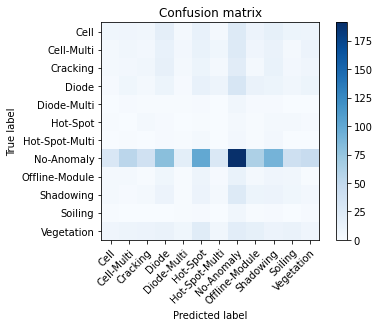

In [ ]:
cm = confusion_matrix(validation_generator_3.classes, y_pred)
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
title = 'Confusion matrix'
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
    yticks=np.arange(cm.shape[0]),
    xticklabels=target_names, yticklabels=target_names,
    title=title,
    ylabel='True label',
    xlabel='Predicted label')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
np.set_printoptions(precision=2)
plt.show()

### Addition: Fine Tuning

In [ ]:
# Freeze all layers until the block_5_ layers
base_model_3.trainable = True
for layer in base_model_3.layers[:-4]:
    layer.trainable = False
    
for layer in base_model_3.layers[0:]:
    print('layer name = ' + layer.name + ', shape = ' + repr(layer.output_shape)
            + ', trainable = ' + repr(layer.trainable))  

layer name = input_3, shape = [(None, 32, 40, 3)], trainable = False
layer name = block1_conv1, shape = (None, 32, 40, 64), trainable = False
layer name = block1_conv2, shape = (None, 32, 40, 64), trainable = False
layer name = block1_pool, shape = (None, 16, 20, 64), trainable = False
layer name = block2_conv1, shape = (None, 16, 20, 128), trainable = False
layer name = block2_conv2, shape = (None, 16, 20, 128), trainable = False
layer name = block2_pool, shape = (None, 8, 10, 128), trainable = False
layer name = block3_conv1, shape = (None, 8, 10, 256), trainable = False
layer name = block3_conv2, shape = (None, 8, 10, 256), trainable = False
layer name = block3_conv3, shape = (None, 8, 10, 256), trainable = False
layer name = block3_pool, shape = (None, 4, 5, 256), trainable = False
layer name = block4_conv1, shape = (None, 4, 5, 512), trainable = False
layer name = block4_conv2, shape = (None, 4, 5, 512), trainable = False
layer name = block4_conv3, shape = (None, 4, 5, 512), train

#### Compute Fine Tuning

In [ ]:
model_3.compile(loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    metrics=["accuracy"])

In [ ]:
logdir = os.path.join("logs_fine_tuning", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))


callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="fine_tuning.keras", save_best_only=True, monitor="val_loss"),
    tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
]

history = model_3.fit(
train_generator_3,
epochs=50,
validation_data = validation_generator_3,
class_weight = class_weights,
callbacks = callbacks
)

Epoch 1/25
400/400 [==============================] - 13s 30ms/step - loss: 1.4406 - accuracy: 0.4490 - val_loss: 1.8710 - val_accuracy: 0.3862
Epoch 2/25
400/400 [==============================] - 12s 29ms/step - loss: 1.3180 - accuracy: 0.4842 - val_loss: 1.4235 - val_accuracy: 0.5369
Epoch 3/25
400/400 [==============================] - 11s 28ms/step - loss: 1.2076 - accuracy: 0.5050 - val_loss: 1.7768 - val_accuracy: 0.3844
Epoch 4/25
400/400 [==============================] - 11s 28ms/step - loss: 1.1143 - accuracy: 0.5080 - val_loss: 1.5671 - val_accuracy: 0.4600
Epoch 5/25
400/400 [==============================] - 11s 28ms/step - loss: 1.1076 - accuracy: 0.5214 - val_loss: 1.5226 - val_accuracy: 0.5013
Epoch 6/25
400/400 [==============================] - 11s 28ms/step - loss: 1.0414 - accuracy: 0.5437 - val_loss: 1.6919 - val_accuracy: 0.4294
Epoch 7/25
400/400 [==============================] - 11s 28ms/step - loss: 1.0048 - accuracy: 0.5434 - val_loss: 1.5121 - val_accuracy:

#### Model Performance - With Fine Tuning

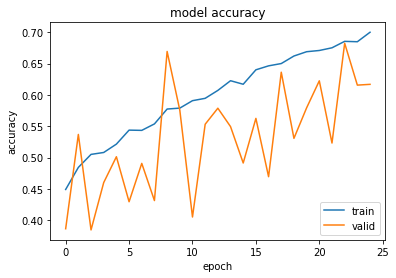

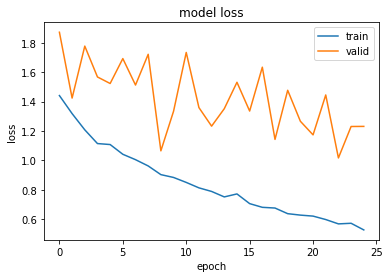

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [ ]:
 model_3.evaluate(validation_generator_3)

50/50 [==============================] - 1s 10ms/step - loss: 1.2310 - accuracy: 0.6169


[1.230952262878418, 0.6168749928474426]

In [ ]:
x = list(train_generator_3.class_indices.keys())
num_of_test_samples = 1600

Y_pred = model_3.predict_generator(validation_generator_3, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print()
print('Confusion Matrix')
print(confusion_matrix(validation_generator_3.classes, y_pred))

print()
print('Classification Report')
target_names = x
print(classification_report(validation_generator_3.classes, y_pred, target_names = target_names))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  after removing the cwd from sys.path.



Confusion Matrix
[[ 16   7   8   9   4  10   2  37  10  10   5  14]
 [ 13   5   9  17   5   6   1  27   6  16   0   8]
 [  9   5   5   8   4   1   1  31   5  16   4   9]
 [ 15   7   8   7   4  10   4  32   8  11   3   8]
 [  4   2   2   1   1   0   0   4   1   1   1   0]
 [  1   2   1   2   0   0   1   7   2   4   0   0]
 [  2   2   1   1   1   0   0   6   2   0   1   2]
 [ 76  38  53  56  15  34  20 255  48  99  14  69]
 [  5   2   6   4   1   4   0  21   4   6   1   5]
 [  9   4   6   4   0   4   5  32   7  13   1   7]
 [  1   1   1   2   0   0   1   6   0   2   0   1]
 [ 22   3   9  16   3   6   6  39  10  11   6  11]]

Classification Report
                precision    recall  f1-score   support

          Cell       0.09      0.12      0.10       132
    Cell-Multi       0.06      0.04      0.05       113
      Cracking       0.05      0.05      0.05        98
         Diode       0.06      0.06      0.06       117
   Diode-Multi       0.03      0.06      0.04        17
      Hot

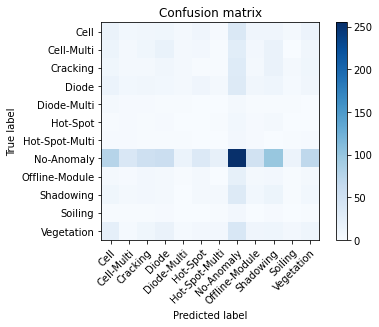

In [ ]:
cm = confusion_matrix(validation_generator_3.classes, y_pred)
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
title = 'Confusion matrix'
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
    yticks=np.arange(cm.shape[0]),
    xticklabels=target_names, yticklabels=target_names,
    title=title,
    ylabel='True label',
    xlabel='Predicted label')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
np.set_printoptions(precision=2)
plt.show()